In [49]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
from astropy.visualization import simple_norm
import astropy.units as u 
from astropy.coordinates import SkyCoord
import regions
from regions import Regions
from astropy.table import Table

from spectral_cube import SpectralCube
import importlib as imp

from dust_extinction.averages import CT06_MWLoc, I05_MWAvg, CT06_MWGC, G21_MWAvg, RL85_MWGC, RRP89_MWGC, F11_MWGC

import matplotlib.pyplot as plt
from reproject import reproject_interp
from reproject.mosaicking import find_optimal_celestial_wcs

In [36]:
cd ..

/blue/adamginsburg/savannahgramze/cloudc/lactea-filament/lactea-filament


In [37]:
import moment_maker as mm
from jwst_plots import JWSTCatalog, make_cat_use, make_brick_cat
import cutout_manager as cm
import jwst_plots
import co_ice as co_map
imp.reload(jwst_plots)
import extinction as ex
#imp.reload(co_map)

In [38]:
cd notebooks

/blue/adamginsburg/savannahgramze/cloudc/lactea-filament/lactea-filament/notebooks


# Examples

In [33]:
basepath = '/orange/adamginsburg/jwst/cloudc/'
cat_fn = f'{basepath}/catalogs/basic_merged_indivexp_photometry_tables_merged.fits'
basetable = Table.read(cat_fn)

In [35]:
bands = [colname[-5:] for colname in basetable.colnames if colname.startswith(f'qfit_')]
bands

['f410m', 'f212n', 'f466n', 'f405n', 'f187n', 'f182m']

In [61]:
qf = 0.4
catalog = basetable.copy()
mask = np.zeros(len(catalog), dtype='bool')

mask = np.logical_or.reduce([np.logical_or(np.array(catalog[f'qfit_{band}']) < qf, np.isnan(np.array(catalog[f'mag_ab_{band}']))) for band in bands])

catalog = catalog[mask]



In [57]:
np.array(basetable[f'qfit_{bands[0]}']) < qf

array([False,  True,  True, ..., False, False, False])

In [58]:
np.isnan(np.array(basetable[f'mag_ab_{bands[0]}']))

array([False, False, False, ...,  True,  True,  True])

In [63]:
catalog

skycoord_ref,skycoord_ref_filtername,sep_f410m,id_f410m,skycoord_f410m,flux_f410m,flux_err_f410m,mask_f410m,qfit_f410m,cfit_f410m,flux_init_f410m,flags_f410m,local_bkg_f410m,group_size_f410m,dra_f410m,ddec_f410m,std_ra_f410m,std_dec_f410m,nmatch_f410m,nmatch_good_f410m,flux_err_prop_f410m,flux_jy_f410m,mag_ab_f410m,eflux_jy_f410m,emag_ab_f410m,near_saturated_f410m_f410m,replaced_saturated_f410m,sep_f212n,id_f212n,skycoord_f212n,flux_f212n,flux_err_f212n,mask_f212n,qfit_f212n,cfit_f212n,flux_init_f212n,flags_f212n,local_bkg_f212n,group_size_f212n,dra_f212n,ddec_f212n,std_ra_f212n,std_dec_f212n,nmatch_f212n,nmatch_good_f212n,flux_err_prop_f212n,flux_jy_f212n,mag_ab_f212n,eflux_jy_f212n,emag_ab_f212n,near_saturated_f212n_f212n,replaced_saturated_f212n,sep_f466n,id_f466n,skycoord_f466n,flux_f466n,flux_err_f466n,mask_f466n,qfit_f466n,cfit_f466n,flux_init_f466n,flags_f466n,local_bkg_f466n,group_size_f466n,dra_f466n,ddec_f466n,std_ra_f466n,std_dec_f466n,nmatch_f466n,nmatch_good_f466n,flux_err_prop_f466n,flux_jy_f466n,mag_ab_f466n,eflux_jy_f466n,emag_ab_f466n,near_saturated_f466n_f466n,replaced_saturated_f466n,sep_f405n,id_f405n,skycoord_f405n,flux_f405n,flux_err_f405n,mask_f405n,qfit_f405n,cfit_f405n,flux_init_f405n,flags_f405n,local_bkg_f405n,group_size_f405n,dra_f405n,ddec_f405n,std_ra_f405n,std_dec_f405n,nmatch_f405n,nmatch_good_f405n,flux_err_prop_f405n,flux_jy_f405n,mag_ab_f405n,eflux_jy_f405n,emag_ab_f405n,near_saturated_f405n_f405n,replaced_saturated_f405n,sep_f187n,id_f187n,skycoord_f187n,flux_f187n,flux_err_f187n,mask_f187n,qfit_f187n,cfit_f187n,flux_init_f187n,flags_f187n,local_bkg_f187n,group_size_f187n,dra_f187n,ddec_f187n,std_ra_f187n,std_dec_f187n,nmatch_f187n,nmatch_good_f187n,flux_err_prop_f187n,flux_jy_f187n,mag_ab_f187n,eflux_jy_f187n,emag_ab_f187n,near_saturated_f187n_f187n,replaced_saturated_f187n,sep_f182m,id_f182m,skycoord_f182m,flux_f182m,flux_err_f182m,mask_f182m,qfit_f182m,cfit_f182m,flux_init_f182m,flags_f182m,local_bkg_f182m,group_size_f182m,dra_f182m,ddec_f182m,std_ra_f182m,std_dec_f182m,nmatch_f182m,nmatch_good_f182m,flux_err_prop_f182m,flux_jy_f182m,mag_ab_f182m,eflux_jy_f182m,emag_ab_f182m,near_saturated_f182m_f182m,replaced_saturated_f182m,flux_jy_410m405,mag_ab_410m405,flux_jy_405m410,mag_ab_405m410,flux_jy_182m187,mag_ab_182m187,flux_jy_187m182,mag_ab_187m182
"deg,deg",,deg,,"deg,deg",,,,,,,,,,,,deg,deg,,,,Jy,,Jy,,,,deg,,"deg,deg",,,,,,,,,,,,deg,deg,,,,Jy,,Jy,,,,deg,,"deg,deg",,,,,,,,,,,,deg,deg,,,,Jy,,Jy,,,,deg,,"deg,deg",,,,,,,,,,,,deg,deg,,,,Jy,,Jy,,,,deg,,"deg,deg",,,,,,,,,,,,deg,deg,,,,Jy,,Jy,,,,deg,,"deg,deg",,,,,,,,,,,,deg,deg,,,,Jy,,Jy,,,,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy
SkyCoord,bytes5,float64,int64,SkyCoord,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,bool,bool,float64,int64,SkyCoord,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,bool,bool,float64,int64,SkyCoord,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,bool,bool,float64,int64,SkyCoord,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,bool,bool,float64,int64,SkyCoord,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,bool,bool,float64,int64,SkyCoord,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,bool,bool,float64,float64,float64,float64,float64,float64,float64,float64
"266.60600142013476,-28.576057219152798",f405n,8.149951888524495e-06,91401,"266.6059933948155,-28.576061312032596",59.30277060563395,12.879229142075488,False,0.

In [39]:
cat_use = make_cat_use()

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [6]:
cat = cat_use.catalog

In [14]:
bandnames = [colname[-5:] for colname in cat.colnames if colname.startswith(f'qfit_')]

In [15]:
bandnames

['f410m', 'f212n', 'f466n', 'f405n', 'f187n', 'f182m']

In [86]:
def get_cutout(filename, position, l, w, format='fits'):
    if format == 'fits':
        try: 
            hdu = fits.open(filename, ext='SCI')[1]
        except: 
            hdu = fits.open(filename)[0]
    elif format == 'casa':
        hdu = SpectralCube.read(filename, format='casa').hdu
    data = np.squeeze(hdu.data)
    head = hdu.header

    ww = WCS(head).celestial
    size = (l, w)
    cutout = Cutout2D(data, position=position, size=size, wcs=ww)
    return cutout

def blind_cutout(filename, position, l, w):
    try:
        cutout = get_cutout(filename, position, l, w)
    except: 
        cutout = get_cutout(filename, position, l, w, format='casa')
    return cutout

def get_cutout_rgb(position, l, w, red_fn, green_fn, blue_fn):
    red_cutout = blind_cutout(red_fn, position, l, w)
    green_cutout = blind_cutout(green_fn, position, l, w)
    blue_cutout = blind_cutout(blue_fn, position, l, w)

    ww = red_cutout.wcs

    if red_cutout.data.shape != green_cutout.data.shape or red_cutout.data.shape != blue_cutout.data.shape:
        hdu_red = fits.PrimaryHDU(data=red_cutout.data, header=red_cutout.wcs.to_header())
        hdu_green = fits.PrimaryHDU(data=green_cutout.data, header=green_cutout.wcs.to_header())
        hdu_blue = fits.PrimaryHDU(data=blue_cutout.data, header=blue_cutout.wcs.to_header())

        ww, shape = find_optimal_celestial_wcs([hdu_red, hdu_green, hdu_blue])
        red_reproj, _ = reproject_interp(hdu_red, ww, shape)
        red_cutout = fits.PrimaryHDU(data=red_reproj, header=ww.to_header())
        green_reproj, _ = reproject_interp(hdu_green, ww, shape)
        green_cutout = fits.PrimaryHDU(data=green_reproj, header=ww.to_header())
        blue_reproj, _ = reproject_interp(hdu_blue, ww, shape)
        blue_cutout = fits.PrimaryHDU(data=blue_reproj, header=ww.to_header())
    
    rgb = np.array([
        red_cutout.data,
        green_cutout.data,
        blue_cutout.data
    ]).swapaxes(0,2).swapaxes(0,1)

    rgb_scaled = np.array([
            simple_norm(rgb[:,:,0], stretch='asinh', vmin=-1, vmax=90)(rgb[:,:,0]),
            simple_norm(rgb[:,:,1], stretch='asinh', vmin=-2, vmax=210)(rgb[:,:,1]),
            simple_norm(rgb[:,:,2], stretch='asinh', vmin=-1, vmax=120)(rgb[:,:,2]),
        ]).swapaxes(0,2)

    return rgb_scaled, ww

In [35]:
from astropy.nddata import Cutout2D
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.io import fits
from astropy import units as u
import numpy as np
from spectral_cube import SpectralCube

In [81]:
fn_212 = '/orange/adamginsburg/jwst/cloudc/images/jw02221-o002_t001_nircam_clear-f212n-merged_i2d.fits'
fn_I1 = '/orange/adamginsburg/cmz/glimpse_data/GLM_00000+0000_mosaic_I1.fits'
fn_405 = '/orange/adamginsburg/jwst/cloudc/images/jw02221-o002_t001_nircam_clear-f405n-merged_i2d.fits'
fn_466 = '/orange/adamginsburg/jwst/cloudc/images/jw02221-o002_t001_nircam_clear-f466n-merged_i2d.fits'
B3_cont_fn = '/orange/adamginsburg/jwst/cloudc/alma/ACES/uid___A001_X15a0_X1a8.s36_0.Sgr_A_star_sci.spw33_35.cont.I.iter1.image.tt0'


In [91]:
clump1 = SkyCoord('17:46:19.2287619119', '-28:38:29.2978617171', unit=(u.hourangle, u.deg))
l = w = 20*u.arcsec
cutout_212 = get_cutout(fn_212, clump1, l, w)
cutout_I1 = get_cutout(fn_I1, clump1, l, w)
cutout_405 = get_cutout(fn_405, clump1, l, w)
cutout_466 = get_cutout(fn_466, clump1, l, w)
cutout_B3 = get_cutout(B3_cont_fn, clump1, l, w, format='casa')

Set DATE-AVG to '2023-04-20T10:21:49.248' from MJD-AVG.
Set DATE-END to '2023-04-25T05:21:01.597' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to    -3.186783 from OBSGEO-[XYZ].
Set OBSGEO-H to 1298882177.580 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2023-04-20T10:07:44.724' from MJD-AVG.
Set DATE-END to '2023-04-25T05:06:53.406' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to    -3.177752 from OBSGEO-[XYZ].
Set OBSGEO-H to 1298809712.873 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2023-04-20T10:21:49.255' from MJD-AVG.
Set DATE-END to '2023-04-25T05:21:01.597' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to    -3.186783 from OBSGEO-[XYZ].
Set OBSGEO-H to 1298882177.580 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
/orange/adamginsburg/miniconda3/envs/python312/lib/python3.12/site-packages/casa_formats_io/casa_dask.py:247: RuntimeWarning: divide by zero encountered in scalar remainder
  factors = [f for f in range(stacks[dim] + 1) if stacks[dim] % f == 0]
Set OBSGEO-

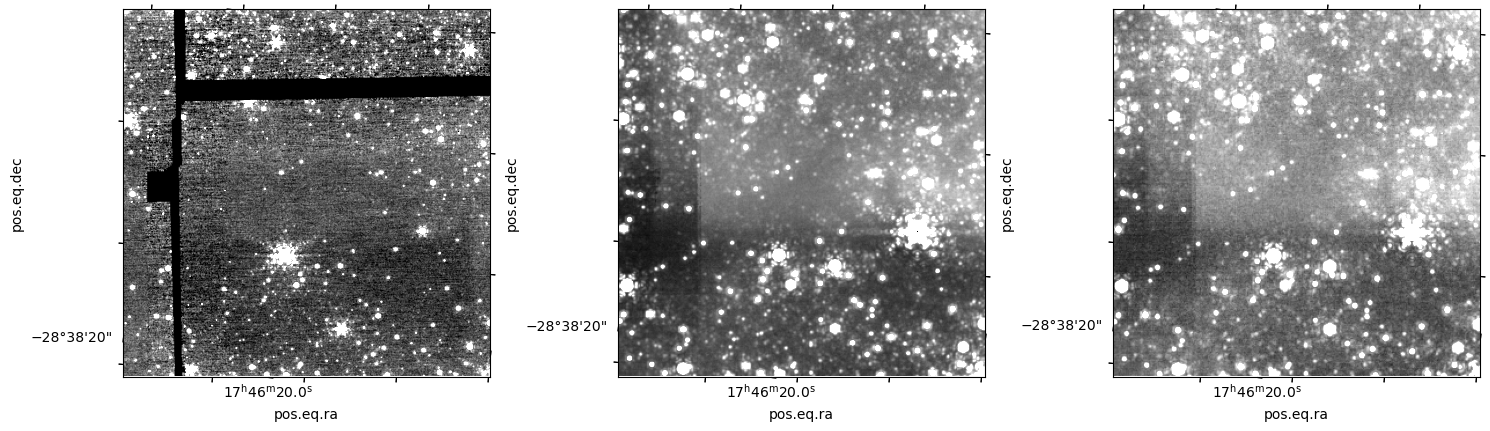

In [92]:
fig = plt.figure(figsize=(15,5))

ax = plt.subplot(131, projection=cutout_212.wcs)
ax.imshow(cutout_212.data, origin='lower', cmap='gray', vmin=0, vmax=25)

ax = plt.subplot(133, projection=cutout_466.wcs)
ax.imshow(cutout_466.data, origin='lower', cmap='gray', vmin=0, vmax=25)

ax = plt.subplot(132, projection=cutout_405.wcs)
ax.imshow(cutout_405.data, origin='lower', cmap='gray', vmin=0, vmax=50)

plt.tight_layout()

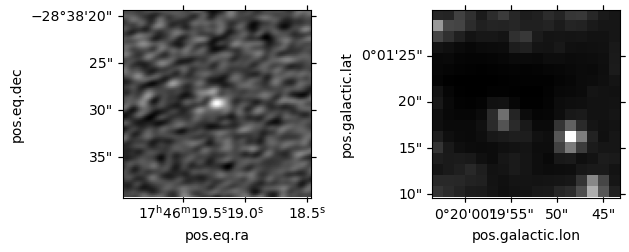

In [93]:
ax = plt.subplot(121, projection=cutout_B3.wcs)
ax.imshow(cutout_B3.data, origin='lower', cmap='gray')

ax = plt.subplot(122, projection=cutout_I1.wcs)
ax.imshow(cutout_I1.data, origin='lower', cmap='gray')

plt.tight_layout()

In [94]:
cutout_rgb, ww = get_cutout_rgb(clump1, l, w, fn_405, fn_212, fn_I1) # fn_466, fn_405, fn_212

Set DATE-AVG to '2023-04-20T10:07:44.724' from MJD-AVG.
Set DATE-END to '2023-04-25T05:06:53.406' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to    -3.177752 from OBSGEO-[XYZ].
Set OBSGEO-H to 1298809712.873 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2023-04-20T10:21:49.248' from MJD-AVG.
Set DATE-END to '2023-04-25T05:21:01.597' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to    -3.186783 from OBSGEO-[XYZ].
Set OBSGEO-H to 1298882177.580 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    -3.177752 from OBSGEO-[XYZ].
Set OBSGEO-H to 1298809712.873 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    -3.186783 from OBSGEO-[XYZ].
Set OBSGEO-H to 1298882177.580 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    -3.177752 from OBSGEO-[XYZ].
Set OBSGEO-H to 1298809712.873 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Set OBSGEO-B to    -3.186783 from OBSGEO-[XYZ].
Set OBSGEO-H to 1298882177.580 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/orange/adamginsburg/miniconda3/envs/python312/lib/python3.12/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)
/orange/adamginsburg/miniconda3/envs/python312/lib/python3.12/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)
/orange/adamginsburg/miniconda3/envs/python312/lib/python3.12/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


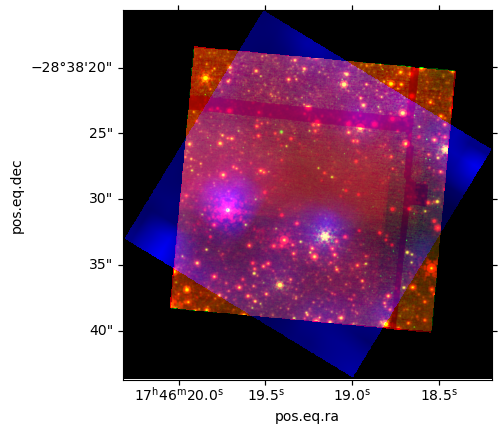

In [95]:
ax = plt.subplot(projection=ww)
ax.imshow(cutout_rgb, origin='lower')

In [96]:
cutout_rgb, ww = get_cutout_rgb(clump1, l, w, B3_cont_fn, fn_405, fn_212) # fn_466, fn_405, fn_212

/orange/adamginsburg/miniconda3/envs/python312/lib/python3.12/site-packages/casa_formats_io/casa_dask.py:247: RuntimeWarning: divide by zero encountered in scalar remainder
  factors = [f for f in range(stacks[dim] + 1) if stacks[dim] % f == 0]
Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2023-04-20T10:07:44.724' from MJD-AVG.
Set DATE-END to '2023-04-25T05:06:53.406' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to    -3.177752 from OBSGEO-[XYZ].
Set OBSGEO-H to 1298809712.873 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2023-04-20T10:21:49.248' from MJD-AVG.
Set DATE-END to '2023-04-25T05:21:01.597' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to    -3.186783 from OBSGEO-[XYZ].
Set OBSGEO-H to 1298882177.580 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -23.022886 

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    -3.177752 from OBSGEO-[XYZ].
Set OBSGEO-H to 1298809712.873 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    -3.186783 from OBSGEO-[XYZ].
Set OBSGEO-H to 1298882177.580 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/orange/adamginsburg/miniconda3/envs/python312/lib/python3.12/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)
/orange/adamginsburg/miniconda3/envs/python312/lib/python3.12/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)
/orange/adamginsburg/miniconda3/envs/python312/lib/python3.12/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


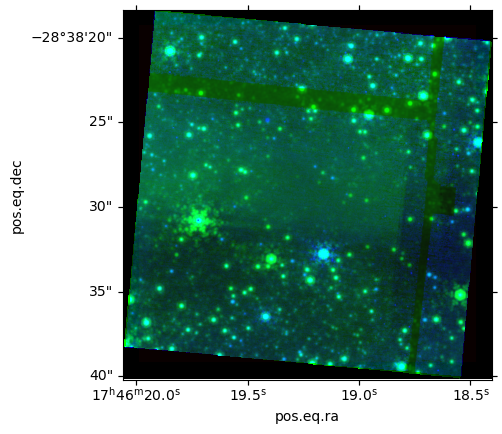

In [97]:
ax = plt.subplot(projection=ww)
ax.imshow(cutout_rgb, origin='lower')